In [2]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np
from scipy.stats import ttest_ind_from_stats

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz, plot_flux
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d
from deeptime.markov.tools import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, _kmeans, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *
from funcs_characterise import *

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
protein = 'abl'
study_name = 'n_clusters'
data_path = Path(f'data_{protein}/msm/{study_name}')
summary_f = data_path/f'{study_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

summary = raw.groupby('hp_id')[['t2', 'gap_2', 't3', 'gap_3']].agg(['mean', 'std'])
summary

t2                   gap_2                       t3  \
               mean           std      mean       std           mean   
hp_id                                                                  
0      1.897906e+06  2.256119e+06  7.204462  9.030466  325705.297247   
1      1.595177e+06  1.815086e+06  4.080848  5.590142  432235.379029   
2      2.136673e+06  3.122491e+06  4.077578  6.400808  535565.850037   
3      2.592150e+06  3.314022e+06  4.691758  5.925844  548228.747968   
4      2.344402e+06  3.034237e+06  4.193718  5.694533  575423.340252   
5      2.326571e+06  3.044765e+06  4.213856  5.890504  578997.424399   

                         gap_3            
                 std      mean       std  
hp_id                                     
0      387121.561458  2.595602  1.789663  
1      290889.808255  2.997026  4.150378  
2      326925.648340  3.210125  3.339652  
3      343147.326564  2.609170  1.852093  
4      413670.471434  2.750514  2.390593  
5      418920.923081  2.803241  2.576391

In [5]:
hp_id = 2
hp_dict = Adict(hps[hps.hp_id == hp_id].to_dict('records')[0])
features = ['dbdist', 'dbdihed', 'aloop', 'ploopdihed', 'achelix']

savedir = Path(f'data_{protein}/msm/validation/{study_name}_hp{hp_id}_validate')
savedir.mkdir(exist_ok=True, parents=True)

hp_dict

{'hp_id': 2,
 'trajlen__cutoff': 1000,
 'n__boot': 20,
 'seed': 49587,
 'tica__lag': 10,
 'tica__stride': 1000,
 'tica__dim': 20,
 'cluster__k': 1000,
 'cluster__stride': 1000,
 'cluster__maxiter': 1000,
 'markov__lag': 100}

In [6]:
ftraj_dir = Path(f'data_{protein}/ftrajs')
ftrajs, traj_mapping = get_data(trajlen_cutoff=hp_dict.trajlen__cutoff, features=features, ftraj_dir=ftraj_dir)

Loading feature:  dbdist


100%|██████████| 749/749 [00:05<00:00, 146.30it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:06<00:00, 110.01it/s]


Loading feature:  aloop


100%|██████████| 749/749 [00:53<00:00, 13.88it/s]


Loading feature:  ploopdihed


0it [00:00, ?it/s]


Loading feature:  achelix


100%|██████████| 749/749 [00:06<00:00, 111.19it/s]

Loaded number of ftrajs: 416


### Estimate a new model given hyperparameters

In [ ]:
ttrajs, tica_mod = _tica(hp_dict, ftrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)[:, :3]
tica_mod.save(savedir/'tica_mod')

In [ ]:
dtrajs, kmeans_mod = _kmeans(hp_dict, ttrajs, seed=hp_dict.seed)
dtraj_cat = np.concatenate(dtrajs, axis=0)
np.save(savedir/f'kmeans_centers.npy', kmeans_mod.clustercenters)

In [ ]:
msm_mod = msm.MaximumLikelihoodMSM(reversible=True, lagtime=hp_dict.markov__lag).fit_fetch(dtrajs)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
np.save(savedir/f'msm_tmat.npy', msm_mod.transition_matrix)

In [ ]:
count_mod = TransitionCountEstimator(lagtime=hp_dict.markov__lag, count_mode='sliding', n_states=hp_dict.cluster__k).fit_fetch(dtrajs)
connected_states = estimation.largest_connected_set(count_mod.count_matrix)
disconnected_states = np.setdiff1d(np.arange(hp_dict.cluster__k), connected_states)
msm_mod = msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(count_mod)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
print(estimation.is_connected(msm_mod.transition_matrix))
np.save(savedir/f'msm_tmat.npy', msm_mod.transition_matrix)
np.save(savedir/f'msm_tcmat.npy', count_mod.count_matrix)

### Load an existing model 

In [7]:
tica_mod = pm.coordinates.tica()
tica_mod = tica_mod.load(savedir/'tica_mod')
ttrajs = tica_mod.transform(ftrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)[:, :3]

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


In [8]:
kmeans_centres = np.load(savedir/f'kmeans_centers.npy', allow_pickle=True)
kmeans_mod = pm.coordinates.cluster_kmeans(fixed_seed=hp_dict.seed)
kmeans_mod.set_model_params(kmeans_centres)
dtrajs = kmeans_mod.transform(ttrajs)
dtrajs = [dtraj.flatten() for dtraj in dtrajs]
dtraj_cat = np.concatenate(dtrajs, axis=0)
index_states = compute_index_states(dtrajs)
#np.savez(savedir/'index_states.npz', *index_states)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


In [9]:
count_mod = TransitionCountEstimator(lagtime=hp_dict.markov__lag, count_mode='sliding', n_states=hp_dict.cluster__k).fit_fetch(dtrajs)
connected_states = estimation.largest_connected_set(count_mod.count_matrix)
disconnected_states = np.setdiff1d(np.arange(hp_dict.cluster__k), connected_states)
msm_mod = msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(count_mod)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
print(estimation.is_connected(msm_mod.transition_matrix))

True


### Where are the cluster centroids on the free energy surface?

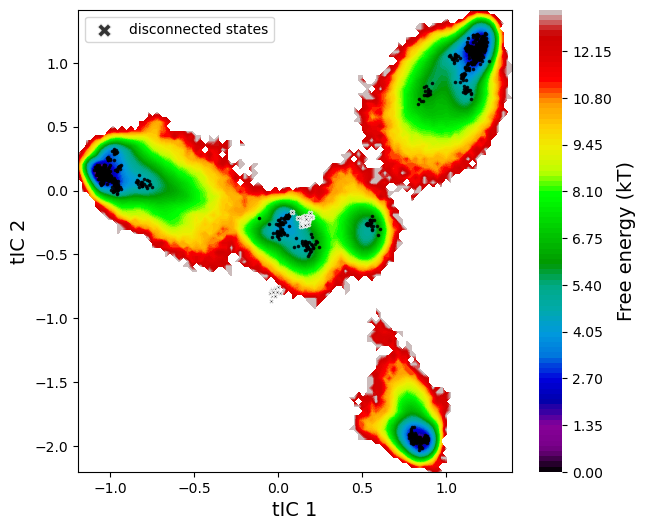

In [9]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers=kmeans_mod.clustercenters[connected_states, :],
        c_centers_s=10,
        d_centers=kmeans_mod.clustercenters[disconnected_states, :],
        d_centers_s=10,
        savedir=savedir/'free_energy.png')

### Timescales

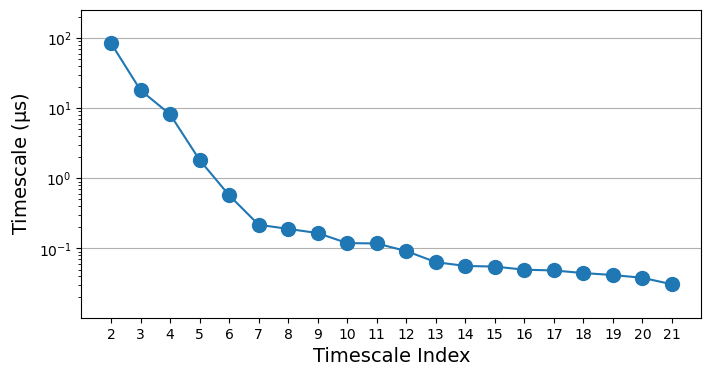

In [10]:
plot_ts(timescales=msm_mod.timescales(), 
        n_ts = 20, 
        markov_lag = hp_dict.markov__lag, 
        scaling = 0.00005, 
        savedir = savedir/'timescales.png', 
        unit="$\mathrm{\mu s}$")

### Coarse-grain with PCCA

In [13]:
n_states = 6
pcca_mod = msm_mod.pcca(n_states)
np.save(savedir/'pcca_memberships.npy', pcca_mod.memberships)
pcca_mod.coarse_grained_stationary_probability

array([0.01167176, 0.0650569 , 0.12467186, 0.16538665, 0.17447607,
       0.45873675])

/home/rzhu/Desktop/projects/kinase_analysis/funcs_plotting.py:82: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],


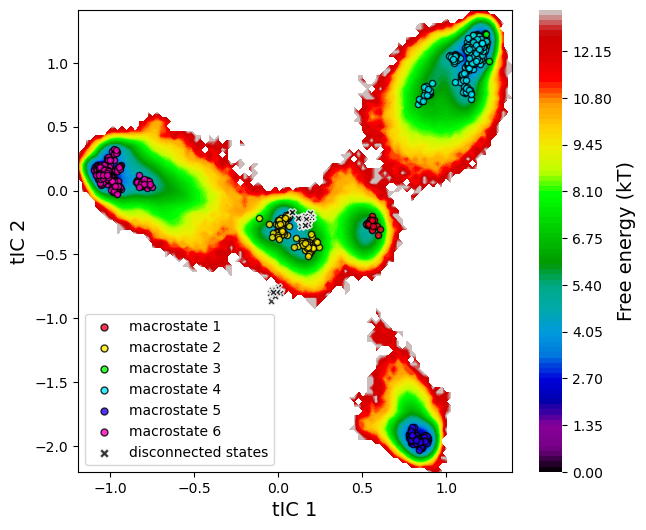

In [12]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers=kmeans_mod.clustercenters[connected_states, :],
        c_centers_s=80,
        state_assignment=pcca_mod.assignments,
        linewidth=1,
        d_centers=kmeans_mod.clustercenters[disconnected_states, :],
        d_centers_s=30,
        d_centers_marker='X',
        legend_marker_sizes=[100, 100, 100, 100, 100, 100, 50],
        savedir = savedir/'pcca.png')

### Project starting conformations onto tICA space

In [13]:
crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").rglob("kinoml*.pdb")])

frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

In [14]:
from funcs_abl_featurise import *
# from funcs_featurise import *

featurisers = [dbdist_featuriser, dbdihed_featuriser, aloop_featuriser, achelix_featuriser]

c_ftrajs = []
for f in featurisers:
    ftraj = f(crystals, save_to_disk=None)
    if 'dihed' in f.__name__:
        ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)    
    c_ftrajs.append(ftraj)
c_ftraj_cat = np.concatenate(c_ftrajs, axis=1)
print(c_ftraj_cat.shape)

c_ttraj = tica_mod.transform(c_ftraj_cat)
print(c_ttraj.shape)

(85, 232)
(85, 20)


In [37]:
import numpy as np

c_dtraj = kmeans_mod.transform(c_ttraj)
connected_d = np.array([idx for idx in c_dtraj if idx in connected_states]).flatten()
disconnected_d = np.array([idx for idx in c_dtraj if idx in disconnected_states]).flatten()

In [41]:
micro_to_macro = {connected_states[i]: pcca_mod.assignments[i] for i in range(len(connected_states))}
c_macro = np.array([micro_to_macro[idx] for idx in connected_d])

In [49]:
def plot_fe(traj_all, traj_weights, savedir, fes_cmap='nipy_spectral', 
            dim_1 = 0, dim_2 = 1, \
            c_centers=None, d_centers=None, 
            c_centers_s=10, c_centers_marker='.', c_centers_a=0.8, c_centers_c='black',
            d_centers_s=10, d_centers_marker='X', d_centers_a=0.8, d_centers_c='black', d_edgecolor='white', d_linewidth=1,
            state_assignment=None, pcca_cmap='gist_rainbow', edgecolor='black', linewidth=1,
            legend_marker_sizes=100,
            title=None):
    
    fig, ax = plt.subplots(figsize=(7, 6))
    ax, contour, cbar = plot_energy2d(energy2d(traj_all[:, dim_1], traj_all[:, dim_2], weights=traj_weights), ax=ax, contourf_kws=dict(cmap=fes_cmap))
    
    if state_assignment is not None:
        n_states = len(np.unique(state_assignment))
        colours = [plt.cm.get_cmap(pcca_cmap)(i/(n_states-1)) for i in range(n_states)]
        for i in range(n_states):
            ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2], 
                       s=c_centers_s, c=colours[i], marker=c_centers_marker, alpha=c_centers_a, 
                       edgecolor=edgecolor, linewidth=linewidth,
                       label=f'macrostate {i+1}')
        legend = plt.legend(markerscale=1, loc='best', fontsize=10)
        
    if (state_assignment is  None) and (c_centers is not None): 
        ax.scatter(c_centers[:,dim_1], c_centers[:,dim_2], s=c_centers_s, c=c_centers_c, marker=c_centers_marker, alpha=c_centers_a)
    
    if d_centers is not None:
        ax.scatter(d_centers[:,dim_1], d_centers[:,dim_2], s=d_centers_s, c=d_centers_c, marker=d_centers_marker, alpha=d_centers_a, 
                   edgecolor=d_edgecolor, linewidth=d_linewidth, label='disconnected states')
        legend = plt.legend(markerscale=1, loc='best', fontsize=10)

    ax.set_xlabel(f'tIC {dim_1+1}', fontsize=14)
    ax.set_ylabel(f'tIC {dim_2+1}', fontsize=14)
    cbar.ax.set_ylabel('Free energy (kT)', fontsize=14)
    if title is not None: ax.set_title(title, fontsize=16)
    
    try:
        if type(legend_marker_sizes) is int: legend_marker_sizes = [legend_marker_sizes] * len(legend.legend_handles)
        for i, handle in enumerate(legend.legend_handles):
            handle.set_sizes([legend_marker_sizes[i]])
    except:
        pass

    if savedir is not None:
        plt.savefig(savedir, transparent=True, bbox_inches='tight', dpi=300)
    plt.show()

    return None

/tmp/ipykernel_171583/3916990922.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colours = [plt.cm.get_cmap(pcca_cmap)(i/(n_states-1)) for i in range(n_states)]
/tmp/ipykernel_171583/3916990922.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],


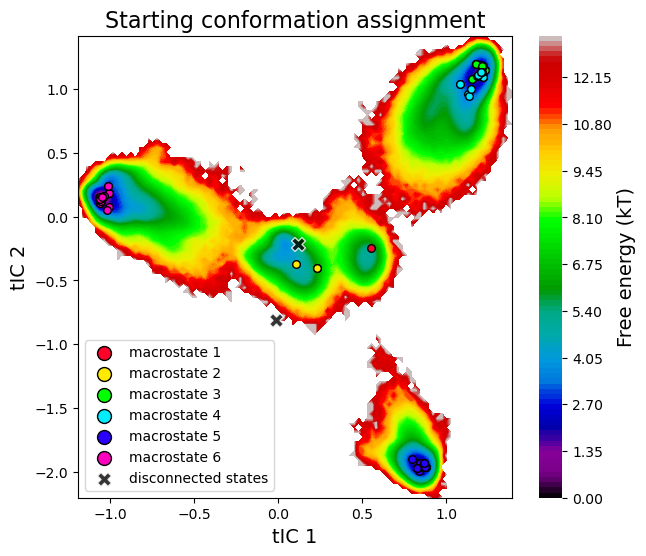

In [52]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[connected_d, :],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 30,
        linewidth=1,
        d_centers=kmeans_mod.clustercenters[disconnected_d, :],
        d_centers_s=100,
        d_centers_marker='X',
        state_assignment=c_macro,
        title='Starting conformation assignment',
        savedir=savedir/'free_energy_with_initial_states.png')

In [53]:
c_dtraj = kmeans_mod.transform(c_ttraj).flatten()
unique, counts = np.unique(pcca_mod.assignments[c_dtraj]+1, return_counts=True)
unique, counts

(array([1, 2, 3, 4, 5, 6]), array([ 2,  6, 12, 13, 11, 41]))

### Coarse-grained transition matrix and MFPT matrix

In [54]:
mfpt = np.zeros([n_states, n_states])

for i in range(n_states):
    for j in range(n_states):
        mfpt[i,j] = msm_mod.mfpt(A=pcca_mod.sets[i], B=pcca_mod.sets[j])

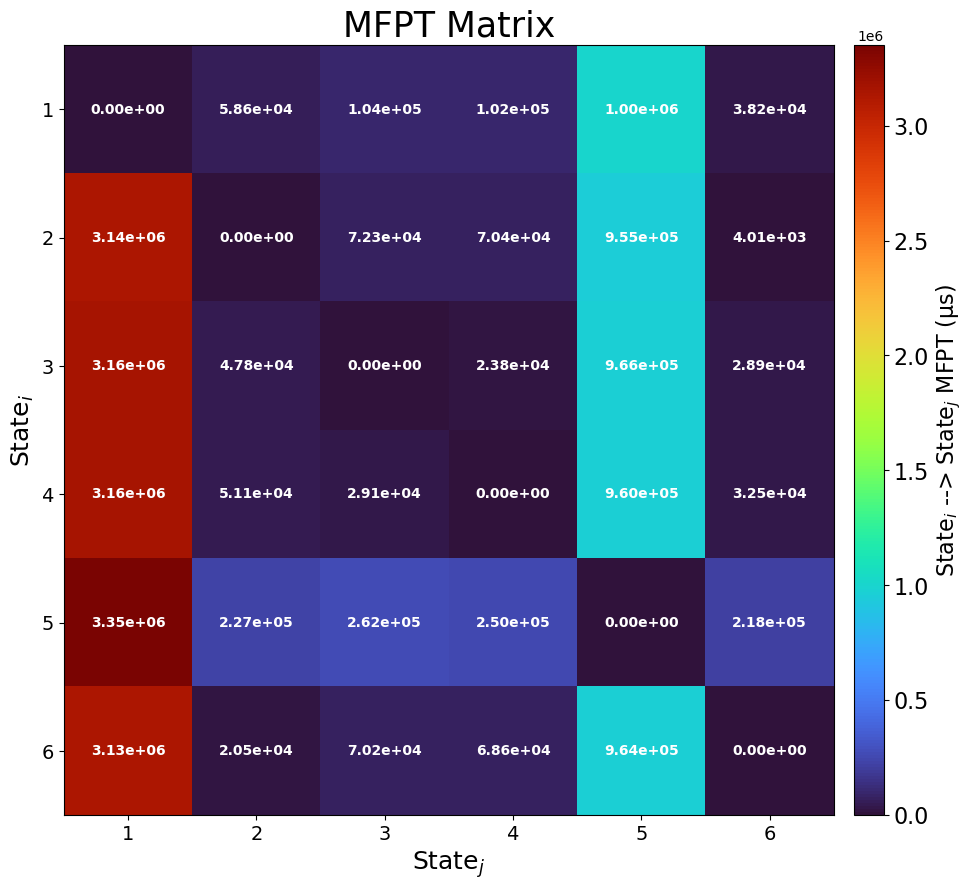

In [55]:
plot_mfpt_matrix(mfpt = mfpt, 
                 savedir = savedir/'mfpt_matrix.png',
                 scaling=0.1, 
                 unit="$\mathrm{\mu s}$", 
                 text_f =".2e")

### Eigenvectors

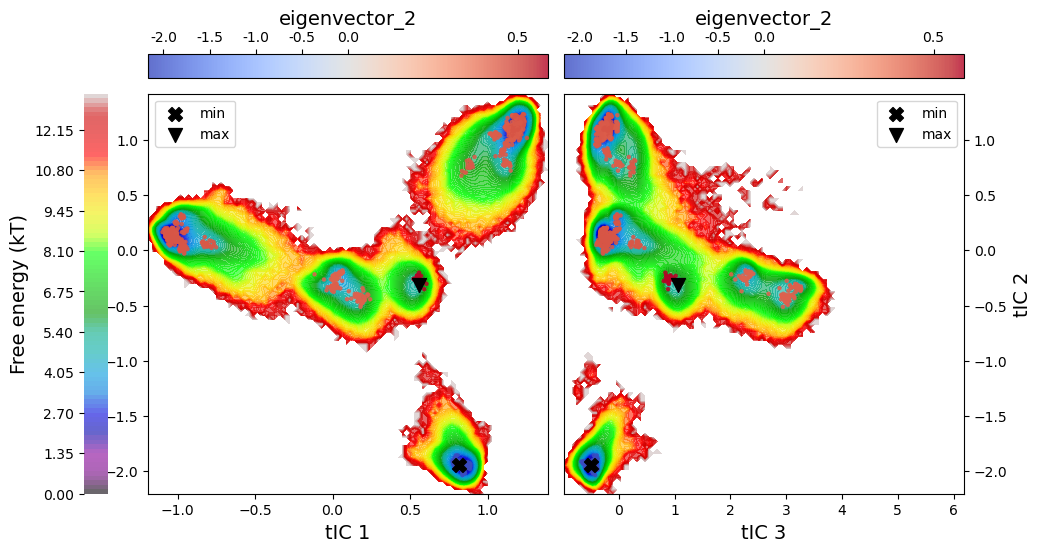

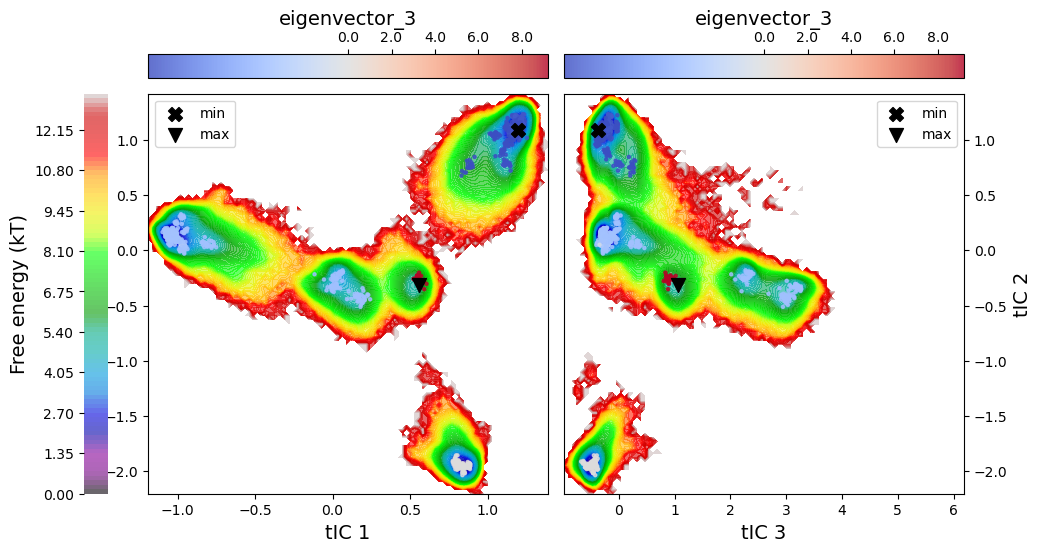

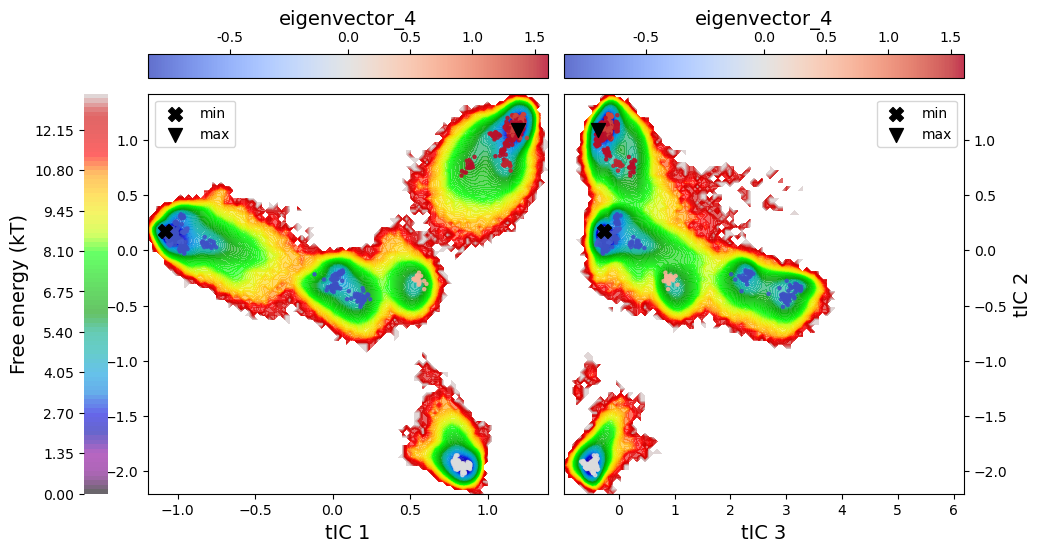

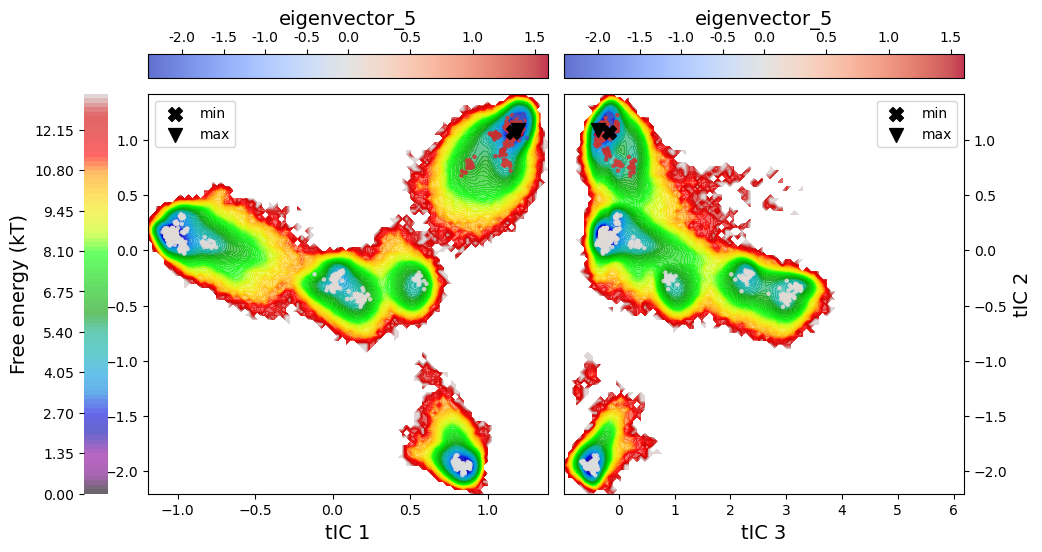

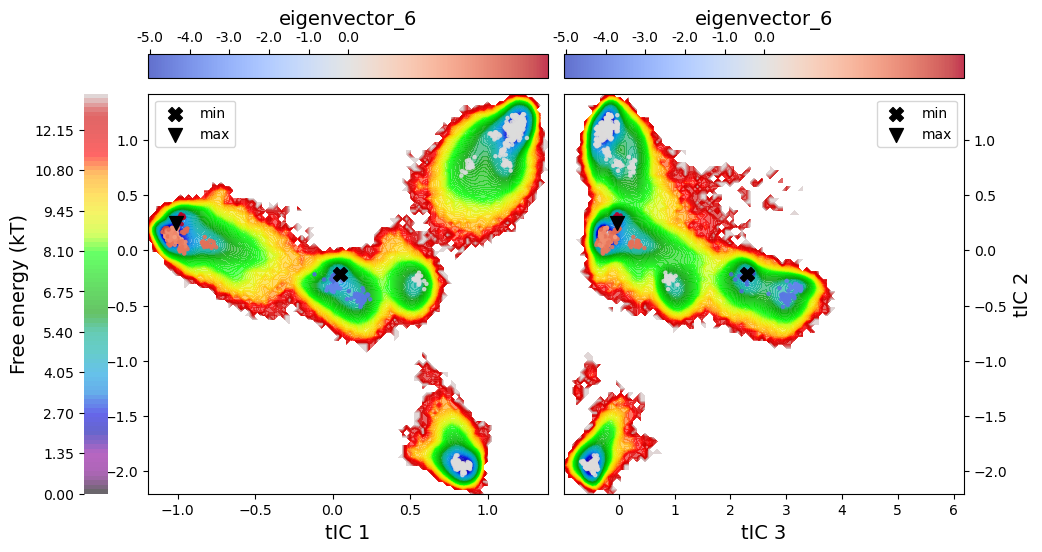

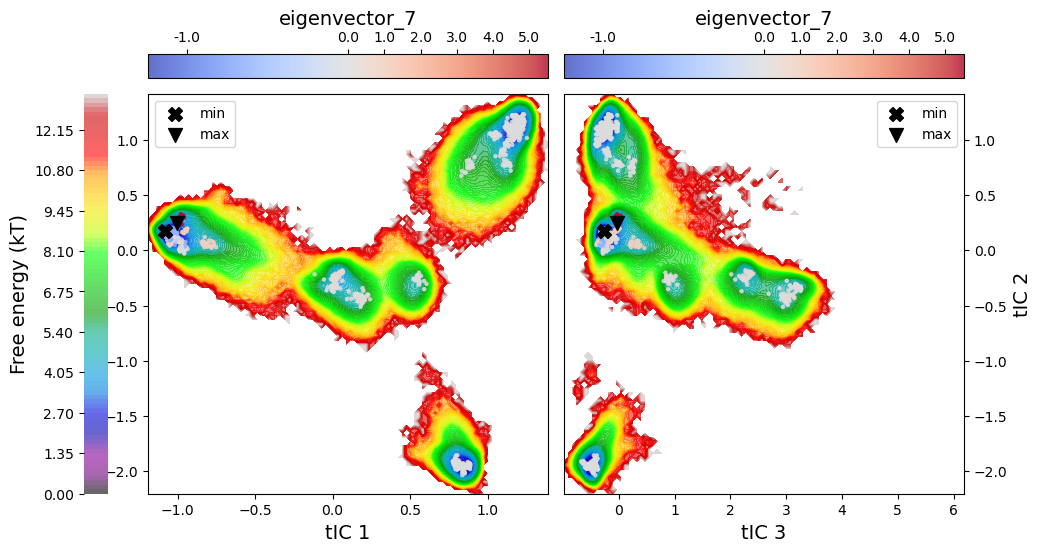

In [56]:
for ev_id in range(6):
        plot_ev(ev = msm_mod.eigenvectors_right()[:,ev_id+1],
                c_centers = kmeans_mod.cluster_centers_[connected_states,:],
                traj_all = ttraj_cat,
                traj_weights = np.concatenate(traj_weights,axis=0),
                title = f'eigenvector_{ev_id+2}',
                savedir = savedir/f'eigenvector_{ev_id+2}.png')

### Sample pcca states and save examples

In [15]:
def sample_states_by_distribution(microstate_distribution, connected_states, n_samples) -> Dict[int, int]:
    """
    Decide how many sample to take from states according to the microstate distribution

    Parameters
    ----------
    microstate_distribution: ndarray( (n) )
        A distribution over microstates to sample from
    n_samples: int
        The number of samples to be taken
    
    Returns
    -------
    state_samples_count: dict
        The states to sampled from : the number of samples to be taken
    """

    state_indices = np.random.choice(len(microstate_distribution), size=n_samples, p=microstate_distribution)
    counts = np.bincount(state_indices)
    state_samples_count = {connected_states[i]:count for i, count in enumerate(counts) if count!=0}

    return state_samples_count

In [16]:
traj_files = natsorted([traj for traj in Path(f'/arc/{protein}_processed').rglob('run*-clone?.h5')])

for state_i in range(n_states):
    membership_cutoff = 0.9  # Only sample microstates that are highly committed to a macrostate

    memberships = pcca_mod.memberships[:,state_i]
    states_to_sample = memberships > membership_cutoff

    stationary_distribution = msm_mod.stationary_distribution.copy()
    stationary_distribution[~states_to_sample] = 0
    sample_distribution = stationary_distribution / np.sum(stationary_distribution)

    state_samples_count = sample_states_by_distribution(sample_distribution, connected_states, 20)
    print(state_samples_count) # Print what microstates are sampled and how many samples from each 
    samples = sample_frames_by_states(state_samples_count, dtrajs, mapping=traj_mapping)
    save_samples(samples, traj_files, savedir/f'MS_{state_i+1}.pdb')

{9: 1, 226: 1, 246: 2, 294: 2, 353: 1, 393: 1, 414: 1, 419: 2, 499: 1, 551: 2, 696: 1, 811: 1, 831: 4}
{359: 2, 394: 1, 508: 1, 585: 1, 654: 9, 674: 1, 763: 2, 778: 1, 903: 2}
{46: 1, 61: 1, 79: 1, 107: 2, 133: 1, 138: 3, 187: 1, 271: 2, 278: 1, 351: 1, 558: 2, 620: 1, 810: 1, 910: 1, 929: 1}
{70: 2, 126: 1, 128: 1, 180: 1, 222: 1, 273: 1, 274: 1, 279: 1, 284: 1, 339: 1, 340: 2, 379: 1, 392: 1, 402: 1, 486: 1, 489: 1, 653: 1, 748: 1}
{124: 1, 139: 1, 155: 1, 188: 2, 221: 1, 227: 1, 247: 1, 250: 2, 384: 1, 427: 1, 554: 1, 751: 1, 761: 2, 780: 1, 782: 1, 978: 1, 985: 1}
{77: 1, 208: 1, 251: 1, 292: 1, 332: 1, 369: 2, 389: 1, 436: 1, 524: 1, 553: 1, 628: 1, 697: 1, 708: 1, 715: 1, 755: 1, 830: 1, 844: 1, 913: 1, 984: 1}


### Sample pcca extreme states

In [17]:
traj_files = natsorted([str(f) for f in Path(f"/arc/{protein}_processed/").rglob('run*-clone?.h5')])
with open(savedir/f'samples.txt', 'w') as f:
    f.writelines(f'macrostate,microstate,traj_id,frame_id\n')

for state_i in range(n_states):
    memberships = pcca_mod.memberships[:,state_i]
    state_samples_count = {connected_states[np.argmax(memberships)] : 1}
    print(state_samples_count) 
    samples = sample_frames_by_states(state_samples_count, dtrajs, mapping=traj_mapping)
    with open(savedir/f'samples.txt', 'a') as f:
        for i, sample in enumerate(samples):
            f.writelines(f'{state_i+1},{[k for k in state_samples_count.keys()][i]},{sample[0]},{sample[1]}\n')
    save_samples(samples, traj_files, savedir/f'MS_{state_i+1}_ex.pdb')

{752: 1}
{508: 1}
{197: 1}
{618: 1}
{99: 1}
{647: 1}


### Sample eigenvector extreme states

In [ ]:
for ev_id in range(6):
    ev = msm_mod.eigenvectors_right()[:,ev_id+1]

    ev_min_sample_count = {np.argmin(ev) : 20}
    ev_max_sample_count = {np.argmax(ev) : 20}
    print(ev_min_sample_count, ev_max_sample_count) 

    samples_min = sample_frames_by_states(ev_min_sample_count, dtrajs, mapping=traj_mapping)
    save_samples(samples_min, traj_files, savedir/f'ev_{ev_id+1}_min.pdb')
    samples_max = sample_frames_by_states(ev_max_sample_count, dtrajs, mapping=traj_mapping)
    save_samples(samples_max, traj_files, savedir/f'ev_{ev_id+1}_max.pdb')

### Transitions from state 1 extreme to 5 

In [ ]:
state_1_ex_id = msm_mod.eigenvectors_right()[:,1].argmax()
state_1_ids = np.where(pcca_mod.memberships[:,0] > 0.9)[0]
state_5_ids = np.where(pcca_mod.memberships[:,4] > 0.9)[0]

In [ ]:
state_1_ids = np.where(pcca_mod.assignments == 0)[0]
state_5_ids = np.where(pcca_mod.assignments == 4)[0]

In [ ]:
simulate_traj = msm_mod.simulate(n_steps=100000, start=state_1_ex_id, seed=hp_dict.seed, stop=state_5_ids)
samples = simulated_traj_to_samples(simulate_traj, dtrajs, mapping=traj_mapping)
np.save(savedir/'1_to_5_simulation.npy', samples)

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[simulate_traj],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 10,
        savedir=savedir/'transition_1_to_5_simulated.png')

In [ ]:
reactive_flux_15 = msm_mod.reactive_flux(state_1_ids, state_5_ids)
major_flux = reactive_flux_15.major_flux()
paths, capacities = reactive_flux_15.pathways()

In [ ]:
sets, cg_flux = reactive_flux_15.coarse_grain(pcca_mod.sets)
ax, pos = plot_flux(cg_flux, flux_scale=100)
ax.set_aspect('equal')

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[paths[1]],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 100,
        savedir=None)

### Transitions from state 5 to state 6 extreme

In [ ]:
state_6_ex_id = msm_mod.eigenvectors_right()[:,5].argmax()
state_6_ids = np.where(pcca_mod.memberships[:,5] > 0.9)[0]
state_5_ids = np.where(pcca_mod.memberships[:,4] > 0.9)[0]

In [ ]:
state_6_ids = np.where(pcca_mod.assignments == 5)[0]
state_5_ids = np.where(pcca_mod.assignments == 4)[0]

In [ ]:
simulate_traj = msm_mod.simulate(n_steps=100000, start=state_6_ex_id, stop=state_5_ids, seed=hp_dict.seed)
samples = simulated_traj_to_samples(simulate_traj, dtrajs, mapping=traj_mapping)
np.save(savedir/'6_to_5_simulation.npy', samples)

In [ ]:
reactive_flux_56 = msm_mod.reactive_flux(state_6_ids, state_5_ids)
major_flux = reactive_flux_56.major_flux()
paths, capacities = reactive_flux_56.pathways()

### Plot reactive flux network 

In [ ]:
sets, cg_flux = reactive_flux_56.coarse_grain(pcca_mod.sets)
ax, pos = plot_flux(cg_flux, flux_scale=100)
ax.set_aspect('equal')